In [209]:
#importeer de juiste packages
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import numpy as np
from keras import regularizers
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import yaml
import matplotlib.image as mpimg
from PIL import Image, ImageDraw
import matplotlib.patches as patches
import os
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l1_l2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import Adam


In [81]:
logs_directory = './logs/logs'
png_file_paths = []
yaml_file_paths = []

for root, dirs, files in os.walk(logs_directory):
    for file in files:
        # Controleer of het bestand een .png-bestand is
        if file.endswith('.png'):
            # Voeg het volledige pad naar het .png-bestand toe aan de lijst
            full_path = os.path.join(root, file)
            png_file_paths.append(full_path)
        if file.endswith('.yaml'):
            full_path = os.path.join(root, file)
            yaml_file_paths.append(full_path)

In [82]:
print(png_file_paths[0])

./logs/logs\2022-04-21_13-39-09.506268_000029\2022-04-21_13-39-09.552741_rgb.png


In [83]:
print(yaml_file_paths[0])

./logs/logs\2022-04-21_13-39-09.506268_000029\2022-04-21_13-39-09.yaml


In [132]:
#output_dir = './logs/output_images'
#os.makedirs(output_dir, exist_ok=True)
 
images = []
shape = []
material = []
 
# Loop door alle PNG- en YAML-bestanden
for image_id in range(len(png_file_paths)):
    img = mpimg.imread(png_file_paths[image_id])  # Laad de afbeelding
 
    with open(yaml_file_paths[image_id]) as file:
        yaml_data = yaml.safe_load(file)  # Laad de YAML-gegevens
 
    sorted_detections = None
    for entry in yaml_data:
        if isinstance(entry, dict) and 'sorted_object_detections' in entry:
            sorted_detections = entry['sorted_object_detections']
            break
 
    if sorted_detections is not None:
        #fig, ax = plt.subplots() !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
 
        # Loop door de gedetecteerde objecten en teken rechthoeken
        for detection in sorted_detections:
            foreground_occlusion = detection['descriptors']['occlusion']['foreground']
 
            # Haal de minimum en maximum coördinaten op voor de box
            if foreground_occlusion > 0.05:
                min_x = detection['box']['minimum'][0]
                min_y = detection['box']['minimum'][1]
                max_x = detection['box']['maximum'][0]
                max_y = detection['box']['maximum'][1]
 
                shapes = detection['descriptors']['shapes']
                best_shape = max(shapes, key=shapes.get)
                shape.append(best_shape)
 
                materials = detection['descriptors']['materials']
                best_material = max(materials, key=materials.get)
                material.append(best_material)
 
                # Teken een rechthoek rond het object
                rect = plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y,
                                     linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
 
                # Bereken het midden van de rechthoek
                center_x = (min_x + max_x) / 2
                center_y = (min_y + max_y) / 2
 
                # Print de detection_id in het midden van de rechthoek
                detection_id = detection['detection_id']
                ax.text(center_x, center_y, str(detection_id), color='blue',
                        fontsize=10, ha='center', va='center', fontweight='bold')
 
                # Snijd de afbeelding uit
                cropped_image = img[min_y:max_y, min_x:max_x]
                resized_image = cv2.resize(cropped_image, (64,64))
                uint8_image = (resized_image * 255).astype(np.uint8)
                images.append(uint8_image)
 
                # Opslaan van de geknipte afbeelding
                #output_path = os.path.join(output_dir, f'{best_shape}_{best_material}_{detection_id}_{image_id}.png')
                #mpimg.imsave(output_path, normalized_image)
 
    else:
        print(f"Geen 'sorted_object_detections' gevonden in de YAML-gegevens voor {yaml_file_paths[image_id]}.")

Geen 'sorted_object_detections' gevonden in de YAML-gegevens voor ./logs/logs\2022-04-25_07-11-27.636472_005012\2022-04-25_07-11-27.yaml.
Geen 'sorted_object_detections' gevonden in de YAML-gegevens voor ./logs/logs\2022-04-25_07-16-32.486398_005156\2022-04-25_07-16-32.yaml.


In [133]:
len(images), len(shape), len(material)

(2414, 2414, 2414)

In [134]:
images = np.array(images)

In [135]:
data = {
    'shape' : shape,
    'material' : material
}

df = pd.DataFrame(data)

In [136]:
df.head()

,shape,material
0,envelope,paper
1,box,cardboard
2,bag,paper
3,box,cardboard
4,bag,soft-plastic


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2414 entries, 0 to 2413
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   shape     2414 non-null   object
 1   material  2414 non-null   object
dtypes: object(2)
memory usage: 37.8+ KB


In [138]:
df['shape'].unique()

array(['envelope', 'box', 'bag'], dtype=object)

In [139]:
df['material'].unique()

array(['paper', 'cardboard', 'soft-plastic', 'undefined'], dtype=object)

In [140]:
df['material'].value_counts()

soft-plastic    1081
cardboard        982
paper            350
undefined          1
Name: material, dtype: int64

In [141]:
# Rijen waar 'material' gelijk is aan 'undefined' vinden
undefined_rows = df[df['material'] == 'undefined']

# Of om alleen de indexen te krijgen:
undefined_indices = df.index[df['material'] == 'undefined'].tolist()

print(undefined_rows)        # Dit toont de rijen met 'undefined'
print(undefined_indices)     # Dit toont de indexen van die rijen


     shape   material
1924   bag  undefined
[1924]


In [142]:
print(images[1924])

[[[ 91  91 100]
  [ 90  91  96]
  [ 84  84  81]
  ...
  [ 39  37  35]
  [ 39  37  40]
  [ 39  38  39]]

 [[ 82  83  79]
  [ 95  95  99]
  [ 96  92  96]
  ...
  [ 36  38  35]
  [ 39  37  40]
  [ 40  36  39]]

 [[ 88  86  87]
  [ 90  92  86]
  [ 97  97 100]
  ...
  [ 37  37  35]
  [ 39  36  39]
  [ 37  39  39]]

 ...

 [[ 47  43  41]
  [ 47  45  43]
  [ 43  43  41]
  ...
  [ 44  45  43]
  [ 45  44  43]
  [ 44  46  43]]

 [[ 45  44  42]
  [ 48  42  44]
  [ 44  45  42]
  ...
  [ 44  45  42]
  [ 46  46  45]
  [ 45  47  41]]

 [[ 45  45  43]
  [ 46  45  44]
  [ 46  43  45]
  ...
  [ 44  44  43]
  [ 47  45  45]
  [ 46  44  44]]]


In [143]:
# Maak een nieuwe DataFrame 'combined_df'
combined_df = pd.DataFrame()
combined_df['combined'] = df.apply(lambda row: f"{row['material']}_{row['shape']}", axis=1)


In [144]:
combined_df

,combined
0,paper_envelope
1,cardboard_box
2,paper_bag
3,cardboard_box
4,soft-plastic_bag
...,...
2409,soft-plastic_bag
2410,cardboard_box
2411,soft-plastic_bag
2412,soft-plastic_bag


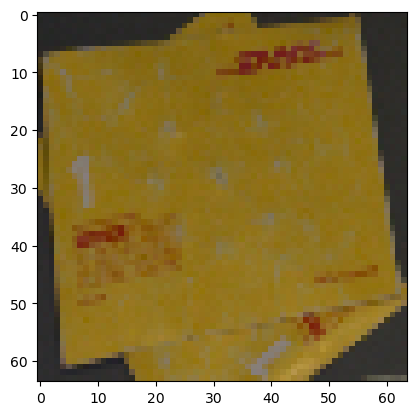

In [145]:
plt.imshow(images[0])  # Display the first image to debug
plt.show()

In [146]:
print(images[0].shape)  # Controleer of de vorm (64, 64, 3) is
print(images[0])  # Controleer de genormaliseerde waarden


(64, 64, 3)
[[[39 40 39]
  [37 38 39]
  [39 38 35]
  ...
  [40 42 39]
  [43 41 38]
  [45 43 41]]

 [[36 38 35]
  [39 38 40]
  [36 39 40]
  ...
  [44 43 39]
  [42 43 41]
  [43 43 37]]

 [[38 38 38]
  [38 39 40]
  [41 40 41]
  ...
  [44 44 41]
  [43 43 40]
  [43 41 37]]

 ...

 [[43 44 45]
  [47 45 47]
  [46 44 49]
  ...
  [49 51 45]
  [53 53 48]
  [52 52 48]]

 [[45 46 47]
  [44 45 43]
  [48 45 47]
  ...
  [53 53 48]
  [54 51 50]
  [54 51 48]]

 [[47 44 46]
  [44 44 46]
  [45 45 46]
  ...
  [92 90 75]
  [89 86 76]
  [99 96 82]]]


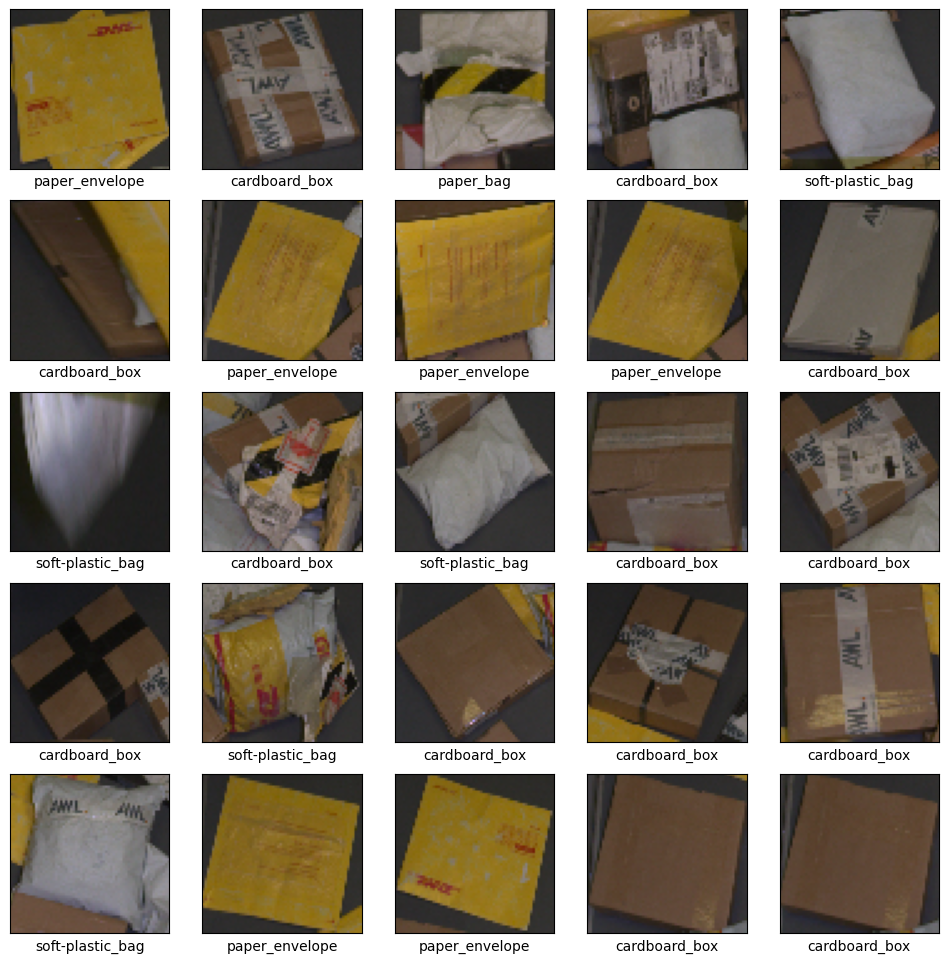

In [147]:
plt.figure(figsize=(12, 12))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i]) 
    plt.xlabel(combined_df['combined'].iloc[i])
    # plt.xlabel(df['shape'].iloc[i] + " " + df['material'].iloc[i]) 
plt.show()

In [148]:
images_org = images.copy()

In [149]:
labels = combined_df['combined']

In [150]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)


In [166]:
from sklearn.preprocessing import LabelEncoder

# Maak een LabelEncoder aan
label_encoder = LabelEncoder()

# Pas de encoder toe op de labels
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Controleer de resultaten
print("Gecodeerde labels (train):", train_labels_encoded)
print("Gecodeerde labels (test):", test_labels_encoded)

# Bekijk de mapping van gecodeerde waarden naar oorspronkelijke labels
label_mapping = dict(enumerate(label_encoder.classes_))
print("Label mapping:", label_mapping)

Gecodeerde labels (train): [1 1 5 ... 5 5 1]
Gecodeerde labels (test): [5 1 5 1 1 1 5 5 5 4 5 1 1 1 5 5 3 1 5 5 5 3 1 5 5 5 1 5 5 1 1 1 5 5 3 1 1
 1 1 1 1 2 5 4 5 1 5 1 4 1 5 1 1 4 4 5 1 5 4 5 1 5 5 1 4 5 1 1 1 5 1 5 1 5
 3 5 5 5 1 5 5 1 5 1 5 1 5 5 1 1 1 5 4 1 1 1 5 5 5 4 5 4 4 5 5 5 1 5 3 1 1
 1 5 5 5 5 1 5 1 4 5 1 5 5 5 4 1 5 1 5 5 5 5 1 1 4 1 1 5 5 4 4 5 5 1 3 5 5
 5 5 5 5 1 1 1 5 1 1 5 5 1 1 1 1 5 4 3 5 5 1 1 5 5 1 4 5 1 1 5 5 1 5 1 1 1
 5 5 0 1 5 5 5 4 5 5 1 5 5 1 4 1 1 1 2 5 5 5 5 4 1 5 1 1 5 3 5 1 1 4 5 5 1
 1 5 5 1 5 5 1 1 1 3 5 4 1 5 5 1 5 5 1 1 3 1 1 5 5 1 5 5 1 1 5 5 5 5 1 5 5
 1 1 4 5 5 2 1 1 1 5 4 1 5 1 5 5 1 1 1 5 1 4 1 4 4 1 5 5 1 1 5 5 5 1 4 1 1
 3 1 5 5 5 4 1 1 1 5 1 5 5 1 1 1 5 3 4 1 1 5 1 5 5 5 1 1 5 4 1 5 1 4 1 5 3
 1 1 5 5 5 1 3 4 4 5 5 3 5 1 1 1 5 1 1 1 5 1 1 1 5 5 3 1 1 5 1 1 5 4 3 5 1
 5 1 1 1 5 1 1 1 1 1 1 1 1 1 5 1 5 1 5 5 5 1 1 3 1 5 1 4 1 4 5 5 1 5 1 5 1
 1 1 3 1 5 5 1 1 0 4 1 5 1 4 5 5 5 5 1 1 1 4 1 4 1 1 4 5 1 5 5 4 1 1 3 2 1
 1 1 4 1 1 5 5 4 4 5 5 1 2 3 

In [164]:
import numpy as np

# Voorbeeld: frequentie van elke unieke waarde in train_labels_encoded
unique, counts = np.unique(train_labels_encoded, return_counts=True)
value_counts = dict(zip(unique, counts))

# Print de waarde tellingen
print(value_counts)


{0: 4, 1: 743, 2: 19, 3: 85, 4: 193, 5: 884, 6: 2, 7: 1}


In [299]:
model = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.35),
    Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.45),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.05)),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Meerdere klassen
])
 


model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_154 (Conv2D)             │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_153         │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_155 (Conv2D)             │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_154         │ (None, 60, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_118               │ (None, 30, 30, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_156 (Conv2D)             │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_155         │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_119               │ (None, 14, 14, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_156         │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_158 (Conv2D)             │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_157         │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_120               │ (None, 7, 7, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_159 (Conv2D)             │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_158         │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_121               │ (None, 3, 3, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 3, 3, 256)      │             

 Total params: 1,139,944 (4.35 MB)

 Trainable params: 1,138,664 (4.34 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [300]:
#compile

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [301]:
datagen = ImageDataGenerator(
    # rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images)

In [302]:
#fit model
history = model.fit(train_images, train_labels_encoded, epochs=30, batch_size=32, validation_data=(test_images, test_labels_encoded))

Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.4229 - loss: 25.7477 - val_accuracy: 0.0373 - val_loss: 24.6562
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.6230 - loss: 23.2331 - val_accuracy: 0.0104 - val_loss: 23.8847
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.6864 - loss: 21.4102 - val_accuracy: 0.3602 - val_loss: 21.4628
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.7278 - loss: 19.8558 - val_accuracy: 0.6667 - val_loss: 19.1649
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.7531 - loss: 18.4653 - val_accuracy: 0.7267 - val_loss: 17.6529
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.7612 - loss: 17.1201 - val_accuracy: 0.7474 - val_loss: 16.3179
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.7757 - loss: 15.8326 - val_accuracy: 0.7764 - val_loss: 15.1142
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.8024 - loss: 14.

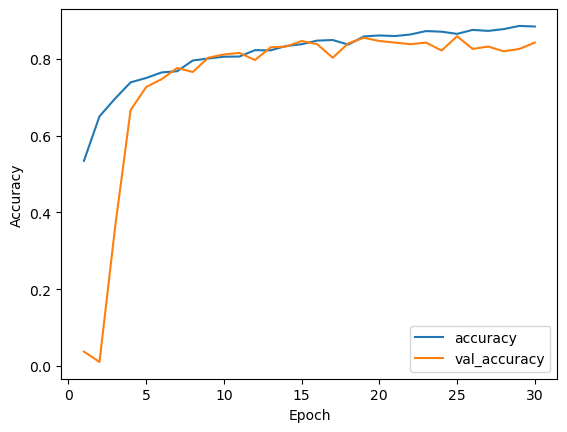

In [303]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)                        
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


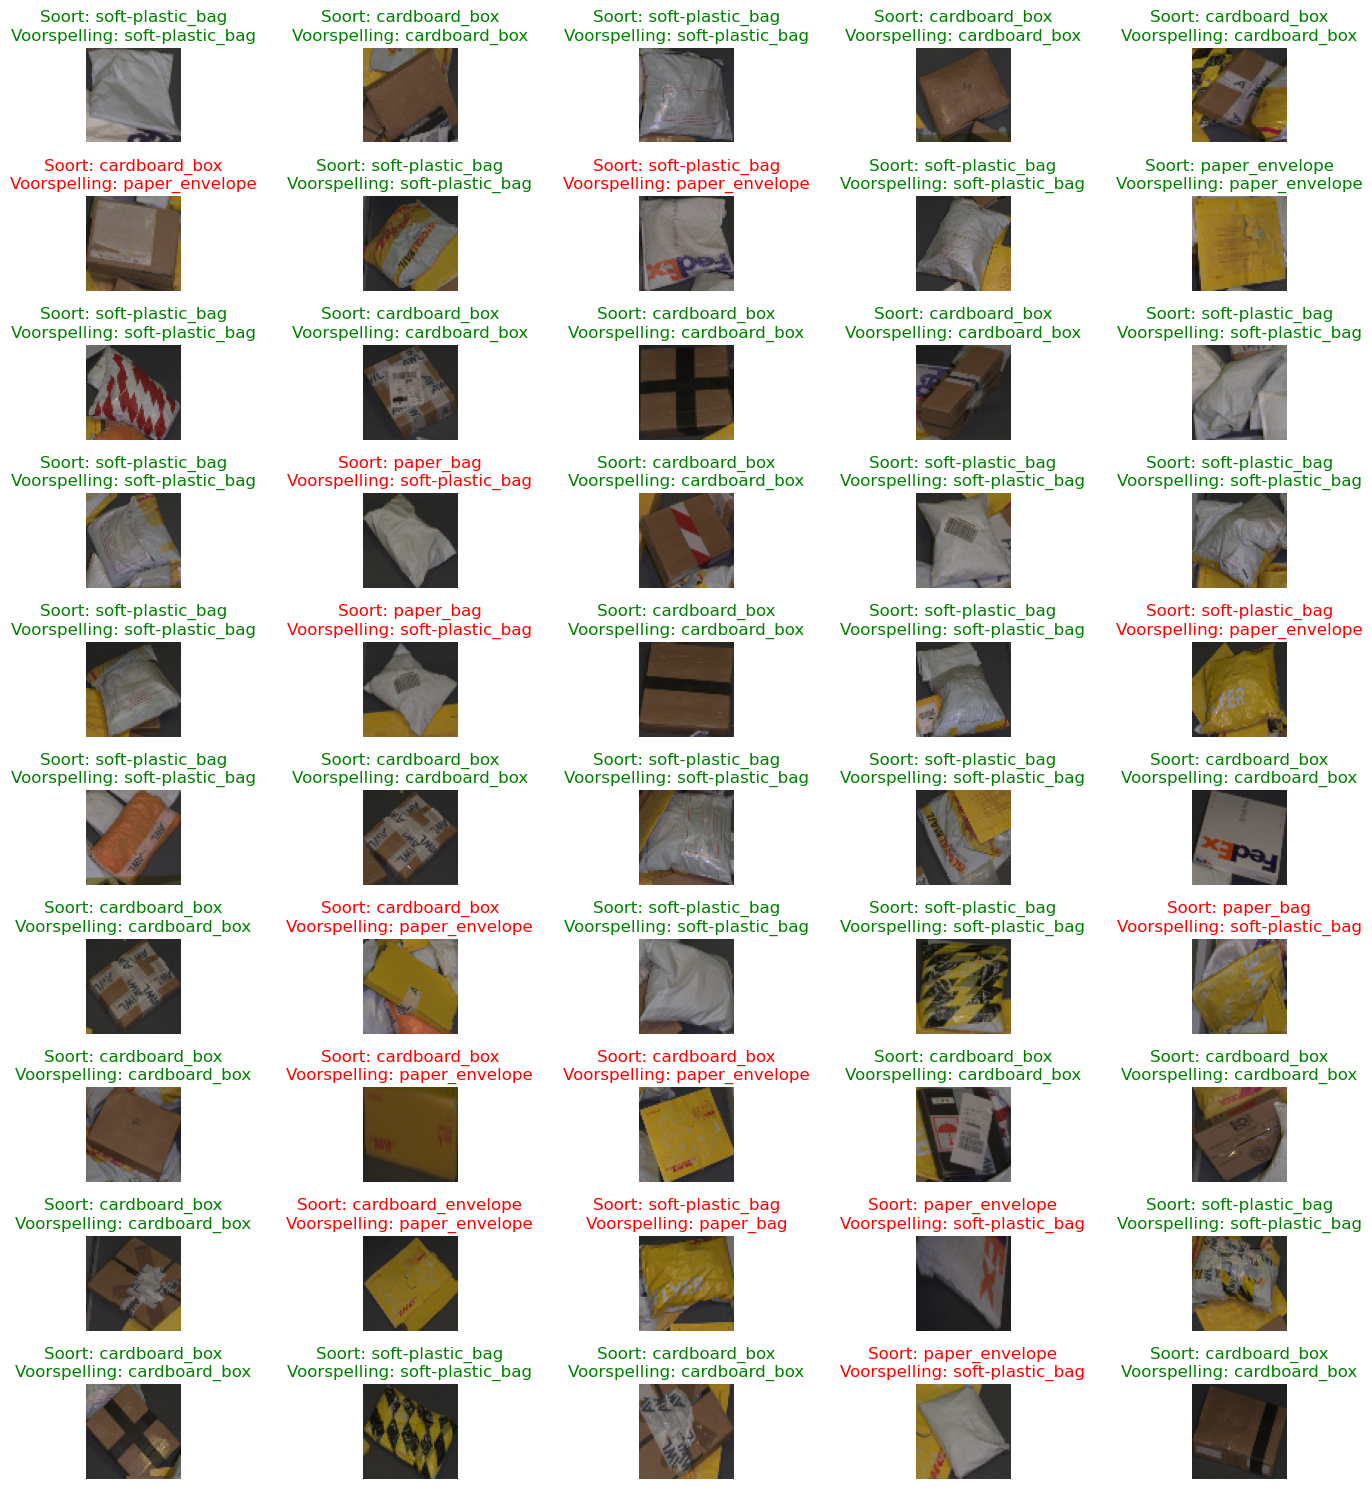

In [304]:
import numpy as np
import matplotlib.pyplot as plt

# Voorspel de labels voor de testset
predicted_labels = model.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)  # Neem de index van de hoogste score

# Haal de oorspronkelijke labelnamen op
true_labels = label_encoder.inverse_transform(test_labels_encoded)  # Echte labels
predicted_labels_names = label_encoder.inverse_transform(predicted_classes)  # Voorspelde labels

# Loop door de eerste 25 afbeeldingen
plt.figure(figsize=(15, 15))
for i in range(50):
    plt.subplot(10, 5, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')  # Verberg de assen

    true_label = true_labels[i]  # Echte label
    predicted_label = predicted_labels_names[i]  # Voorspelde label

    # Kleur de tekst op basis van overeenstemming
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f'Soort: {true_label}\nVoorspelling: {predicted_label}', color=color, fontsize=12)

plt.tight_layout()
plt.show()



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


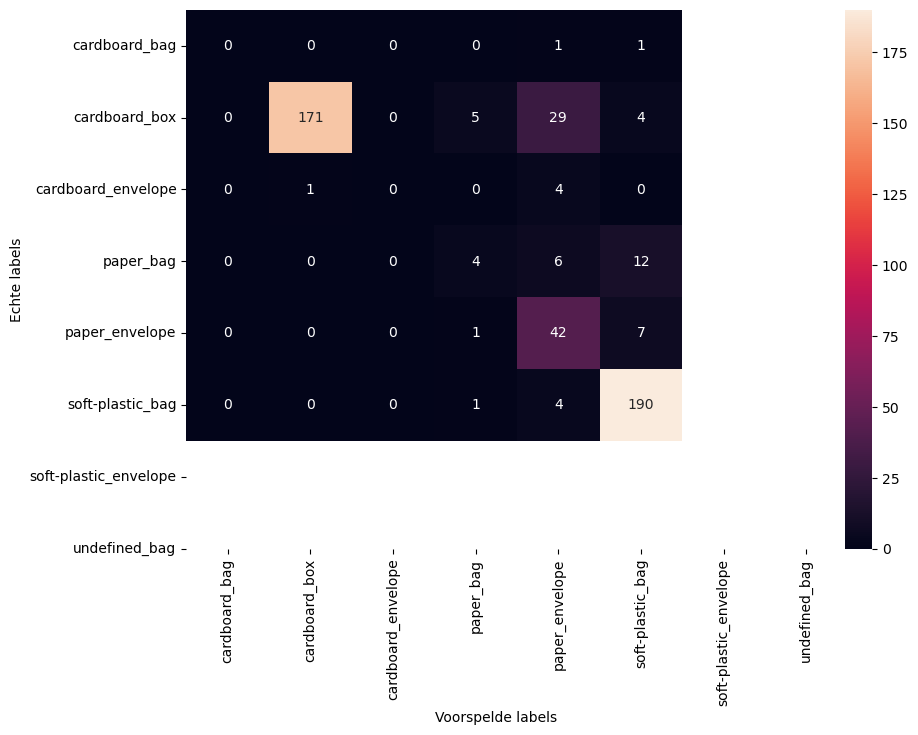

In [305]:
# Voorspel de labels voor de testset
predicted_labels = model.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)  # Neem de index van de hoogste score

# Gebruik de originele labels
true_labels = test_labels_encoded  # Deze moeten in de juiste vorm zijn

# Bereken de verwarring matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Visualiseer de verwarring matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Voorspelde labels')
plt.ylabel('Echte labels')
plt.show()

In [62]:
y_shape = df['shape'].values
y_material = df['material'].values

# Convert labels to numerical format using LabelEncoder
label_encoder_shape = LabelEncoder()
label_encoder_material = LabelEncoder()

# Fit and transform the labels
y_shape_encoded = label_encoder_shape.fit_transform(y_shape)
y_material_encoded = label_encoder_material.fit_transform(y_material)

X_train, X_test, y_shape_train, y_shape_test, y_material_train, y_material_test = train_test_split(
    images, y_shape_encoded, y_material_encoded, test_size=0.2, random_state=42)

In [67]:
print(y_shape.shape)

(2414,)


In [63]:
model = keras.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(len(label_encoder_shape.classes_), activation='softmax', name='shape_output'),
    Dense(len(label_encoder_material.classes_), activation='softmax', name='material_output')
])

model.summary()

C:\Users\matth\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       984,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shape_output (Dense)            │ (None, 3)              │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ material_output (Dense)         │ (None, 4)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 998,867 (3.81 MB)

 Trainable params: 998,707 (3.81 MB)

 Non-trainable params: 160 (640.00 B)

In [64]:
#compile
model.compile(optimizer="ADAM",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [65]:
history = model.fit(
    X_train,
    {'shape_output': y_shape_train, 'material_output': y_material_train},
    epochs=100,
    validation_data=(X_test, {'shape_output': y_shape_test, 'material_output': y_material_test})
)


Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.6028 - loss: 1.1896 - val_accuracy: 0.4244 - val_loss: 1.1943
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.6831 - loss: 1.0968 - val_accuracy: 0.4306 - val_loss: 1.1869
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6228 - loss: 1.1032 - val_accuracy: 0.5590 - val_loss: 1.0997
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.6289 - loss: 1.0447 - val_accuracy: 0.6377 - val_loss: 1.0264
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.6843 - loss: 1.0011 - val_accuracy: 0.6894 - val_loss: 0.9733
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.7020 - loss: 0.9550 - val_accuracy: 0.4576 - val_loss: 1.2251
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.6670 - loss: 0.9673 - val_accuracy: 0.6936 - val_loss: 0.9104
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.7075 - loss: 0.9125 - val_acc

61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.7418 - loss: 0.7014 - val_accuracy: 0.7371 - val_loss: 0.7221
Epoch 52/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.7289 - loss: 0.7210 - val_accuracy: 0.6853 - val_loss: 0.7933
Epoch 53/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.7434 - loss: 0.7104 - val_accuracy: 0.6501 - val_loss: 0.8019
Epoch 54/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.7586 - loss: 0.6980 - val_accuracy: 0.6522 - val_loss: 0.8056
Epoch 55/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.7602 - loss: 0.6726 - val_accuracy: 0.6004 - val_loss: 0.9419
Epoch 56/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.7472 - loss: 0.7086 - val_accuracy: 0.6998 - val_loss: 0.8004
Epoch 57/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.7330 - loss: 0.7235 - val_accuracy: 0.7288 - val_loss: 0.7555
Epoch 58/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.7467 - loss: 0.6888 - val_accuracy:

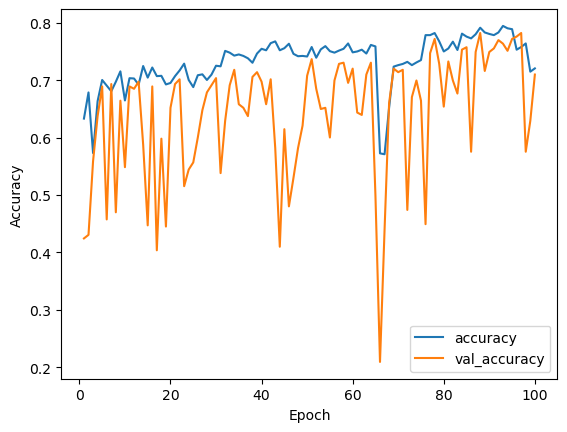

In [66]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)                        
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')